In [60]:
import os
import csv

import cv2
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

## Model definition

In [61]:
### Model Parameters
conv_dropout = 0.4
dense_dropout = 0.5
l2_regularization = 0.001

# l1_regularizer = tf.keras.regularizers.l1(0.01)
l2_regularizer = None #tf.keras.regularizers.l2(l2_regularization)

CROP_UP = 50
CROP_DOWN = 30
final_height = 160 - (CROP_UP + CROP_DOWN)

In [62]:
### Aux functions for batchnorm layers
def conv2d_batch_norm(*args, **kwargs):

    activation = kwargs.pop("activation", None)
    batch_norm = kwargs.pop("batch_norm", {})

    net = tf.layers.conv2d(*args, **kwargs)
    net = tf.layers.batch_normalization(net, **batch_norm)

    return activation(net) if activation else net

def dense_batch_norm(*args, **kwargs):

    activation = kwargs.pop("activation", None)
    batch_norm = kwargs.pop("batch_norm", {})

    net = tf.layers.dense(*args, **kwargs)
    net = tf.layers.batch_normalization(net, **batch_norm)

    return activation(net) if activation else net

In [63]:
mu = 0
sigma = 0.1
init = None #tf.initializers.truncated_normal(mean = mu, stddev = sigma)


def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features, [-1, final_height, 320, 3])

    general_ops = dict(
#         activation = activation,
        batch_norm = dict(training = mode == tf.estimator.ModeKeys.TRAIN)
#         kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_regularization),
    )
                                             
    input_normalized = tf.layers.batch_normalization(input_layer, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    # Convolutional Layer #1
    conv1 = conv2d_batch_norm(
      inputs=input_normalized,
      filters=32,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu, kernel_initializer=init,
      **general_ops)
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    pool1 = tf.layers.dropout(
        inputs=pool1, 
        rate=conv_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = conv2d_batch_norm(
      inputs=pool1,
      filters=32,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu, kernel_initializer=init,
    **general_ops)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2 = tf.layers.dropout(
        inputs=pool2, 
        rate=conv_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)
                                             
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = conv2d_batch_norm(
      inputs=pool2,
      filters=64,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu, kernel_initializer=init,
    **general_ops)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    pool3 = tf.layers.dropout(
        inputs=pool3, 
        rate=conv_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)  
                                             
    # Convolutional Layer #4 and Pooling Layer #4
    conv4 = conv2d_batch_norm(
      inputs=pool3,
      filters=64,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu, kernel_initializer=init,
    **general_ops)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    pool4 = tf.layers.dropout(
        inputs=pool4, 
        rate=conv_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)  
                                             
    # Dense Layers
    pool_flat = tf.layers.flatten(conv4)
    
    dense1 = dense_batch_norm(inputs=pool_flat,
                             units=1024,
                             activation=tf.nn.relu,
                             kernel_initializer=init,
                             **general_ops)
    dense1 = tf.layers.dropout(
        inputs=dense1, 
        rate=dense_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)
    
    dense2 = dense_batch_norm(inputs=dense1,
                             units=512,
                             activation=tf.nn.relu,
                             kernel_initializer=init,
                             **general_ops)
    dense2 = tf.layers.dropout(
        inputs=dense2, 
        rate=dense_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)
                                             
    dense3 = dense_batch_norm(inputs=dense2,
                             units=128,
                             activation=tf.nn.relu,
                             kernel_initializer=init,
                             **general_ops)
    dense3 = tf.layers.dropout(
        inputs=dense3, 
        rate=dense_dropout, 
        training= mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    preds = tf.layers.dense(inputs=dense3, units=1, kernel_initializer=init, use_bias=False)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "steering": preds,
    "image": input_layer
    }


    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    with tf.name_scope('loss'):
            loss = tf.losses.mean_squared_error(
                labels=labels, predictions=tf.squeeze(preds, axis = 1), scope='loss')
            tf.summary.scalar('loss', loss)
    
    # Accuracy    
    with tf.name_scope('mae'):
            mae = tf.metrics.mean_absolute_error(
                labels=labels, predictions=tf.squeeze(preds, axis = 1), name='mae')
            tf.summary.scalar('mae', mae[1])

    # Create a hook to print acc, loss & global step every 100 iter.   
    train_hook_list= []
    train_tensors_log = {'mae': mae[1],
                         'loss': loss}
    train_hook_list.append(tf.train.LoggingTensorHook(
        tensors=train_tensors_log, every_n_iter=100))

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
#             optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
#             optimizer = tf.train.AdagradOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())
    
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            loss=loss, 
            train_op=train_op, 
            training_hooks=train_hook_list)

    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops={'mae/mae': mae}, evaluation_hooks=None)


In [64]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/pilotnetV1_test")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_num_ps_replicas': 0, '_eval_distribute': None, '_save_checkpoints_steps': None, '_evaluation_master': '', '_experimental_distribute': None, '_task_id': 0, '_keep_checkpoint_max': 5, '_service': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_train_distribute': None, '_save_checkpoints_secs': 600, '_device_fn': None, '_global_id_in_cluster': 0, '_is_chief': True, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd2b4180518>, '_save_summary_steps': 100, '_model_dir': '/tmp/pilotnetV1_test'}


## Dataset creation

In [65]:
### folder where the data is
DATASET = "data_mine"

In [66]:
def read_img(name):
    img = name.split('/')[-1]
    return cv2.imread(os.path.join(DATASET,"IMG", img))

In [67]:
### Load csv as a pandas dataframe
header = ["center", "left", "right", "steering", "throttle", "break", "speed"]
df = pd.read_csv(os.path.join(DATASET, "driving_log.csv"), header=None, names=header)
df.head()

,center,left,right,steering,throttle,break,speed
0,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000020
1,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000011
2,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000011
3,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000021
4,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000016


In [68]:
def get_image_path(filename):
    return os.path.join(DATASET,"IMG", filename.split("/")[-1])

In [69]:
### Make paths relative to this jupyter notebook
df["center"] = df.center.apply(get_image_path)
df["left"] = df.left.apply(get_image_path)
df["right"] = df.right.apply(get_image_path)
df["steering"] = df.steering.apply(float)
df.head()

,center,left,right,steering,throttle,break,speed
0,data_mine/IMG/center_2019_02_03_21_24_02_332.jpg,data_mine/IMG/left_2019_02_03_21_24_02_332.jpg,data_mine/IMG/right_2019_02_03_21_24_02_332.jpg,0.0,0.0,0,0.000020
1,data_mine/IMG/center_2019_02_03_21_24_02_398.jpg,data_mine/IMG/left_2019_02_03_21_24_02_398.jpg,data_mine/IMG/right_2019_02_03_21_24_02_398.jpg,0.0,0.0,0,0.000011
2,data_mine/IMG/center_2019_02_03_21_24_02_467.jpg,data_mine/IMG/left_2019_02_03_21_24_02_467.jpg,data_mine/IMG/right_2019_02_03_21_24_02_467.jpg,0.0,0.0,0,0.000011
3,data_mine/IMG/center_2019_02_03_21_24_02_536.jpg,data_mine/IMG/left_2019_02_03_21_24_02_536.jpg,data_mine/IMG/right_2019_02_03_21_24_02_536.jpg,0.0,0.0,0,0.000021
4,data_mine/IMG/center_2019_02_03_21_24_02_605.jpg,data_mine/IMG/left_2019_02_03_21_24_02_605.jpg,data_mine/IMG/right_2019_02_03_21_24_02_605.jpg,0.0,0.0,0,0.000016


In [70]:
### Split train and dev set 
train_samples, validation_samples = train_test_split(df, test_size=0.2)

In [71]:
from data_augmentation import get_seq
NUMBER_AUGMENTATIONS = 3

In [72]:
def single_generator(filenames, labels):
    seq = get_seq(NUMBER_AUGMENTATIONS)
    while 1: # Loop forever so the generator never terminates
        for filename, label in zip(filenames, labels):

            y_train = label
            image = read_img(filename)
            

            # define images for training
            X_train = image[CROP_UP:-CROP_DOWN,:,:]
            X_train = seq.augment_image(X_train).astype(np.float32)
            yield (X_train, y_train)

In [73]:
# Get filenames and labels (steerings)
c_filenames = train_samples.center.values
c_labels = train_samples.steering.values

val_filenames = validation_samples.center.values
val_labels = validation_samples.steering.values

In [74]:
train_samples.steering.values

array([ 0.        ,  0.05660377,  0.        , ...,  0.        ,
        0.2358491 , -0.01886792])

In [75]:
# Add side cameras to train set
steer_correction = 0.2

l_filenames = train_samples.left.values
l_labels = train_samples.steering.values + steer_correction

r_filenames = train_samples.right.values
r_labels = train_samples.steering.values - steer_correction

filenames = np.concatenate([c_filenames, l_filenames, r_filenames])
labels = np.concatenate([c_labels, l_labels, r_labels])

In [76]:
train_generator = single_generator(filenames, labels)
eval_generator = single_generator(val_filenames, val_labels)
x,y=next(train_generator)
x.shape, y.shape

((80, 320, 3), ())

In [77]:
# Aux function to crop the images
def get_crop_window(crop_up, crop_down):
    final_height = 160 - (crop_up + crop_down)
    final_width = 320

    return [
        crop_up,
        0,
        final_height,
        final_width,
    ]

In [78]:
# Function that returns the image decoded from jpg and label

def parse_function(image, label):
#     image_string = tf.read_file(filename)

#     # Don't use tf.image.decode_image, or the output shape will be undefined
#     image = tf.image.decode_jpeg(image_string, channels=3)
    
#     image = tf.image.decode_and_crop_jpeg(
#             image_string,
#             crop_window = get_crop_window(CROP_UP, CROP_DOWN),
#             channels = 3
#         )

    # This will convert to float values in [0, 1]
#     image = tf.image.convert_image_dtype(image, tf.float32)

#     image = tf.image.resize_images(image, [160, 320])
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    return image, label

### Use of TF DataSet API

In [79]:
# Define parameters
BATCH_SIZE = 32
EPOCHS = 26
steps_per_epoch = len(train_samples)*3//BATCH_SIZE

In [80]:
# Create training dataset
def create_train_dataset():
    dataset = tf.data.Dataset.from_generator(generator=lambda: train_generator,
                                         output_types=(tf.float32, tf.float32))
    dataset = dataset.shuffle(len(train_samples))
#     dataset = dataset.map(parse_function, num_parallel_calls=4)
    dataset = dataset.repeat(EPOCHS)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

In [81]:
# Create dev dataset
def create_eval_dataset():
    val_dataset = tf.data.Dataset.from_generator(generator=lambda: eval_generator,
                                         output_types=(tf.float32, tf.float32))
#     val_dataset = val_dataset.map(parse_function, num_parallel_calls=4)
    val_dataset = val_dataset.repeat(EPOCHS)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(1)
    return val_dataset

In [82]:
# # Get image example for trainig
sess = tf.Session()
value = create_train_dataset().make_one_shot_iterator().get_next()
x,y = sess.run(value)

(32, 80, 320, 3) (32,)


array([[[111., 150.,   0.],
        [117., 155.,   0.],
        [122., 158.,   0.],
        ...,
        [ 93.,   0.,  79.],
        [ 96.,   0.,  85.],
        [101.,   0.,  91.]],

       [[111., 137.,   0.],
        [118., 144.,   0.],
        [123., 148.,   0.],
        ...,
        [ 93.,   0.,  78.],
        [ 96.,   0.,  84.],
        [101.,   0.,  90.]],

       [[109., 127.,   0.],
        [117., 134.,   0.],
        [124., 140.,   0.],
        ...,
        [ 91.,   0.,  78.],
        [ 96.,   0.,  84.],
        [100.,   0.,  90.]],

       ...,

       [[ 94.,   0., 134.],
        [ 93.,   0., 132.],
        [ 93.,   0., 131.],
        ...,
        [104., 128., 148.],
        [103., 126., 146.],
        [100., 124., 144.]],

       [[ 95.,   0., 134.],
        [ 94.,   0., 133.],
        [ 93.,   0., 131.],
        ...,
        [111., 135., 155.],
        [109., 132., 153.],
        [106., 130., 150.]],

       [[ 97.,   0., 135.],
        [ 95.,   0., 133.],
        [ 93.,  

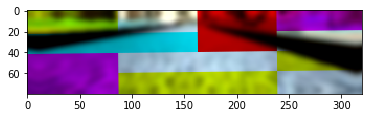

In [83]:
print(x.shape, y.shape)
plt.imshow(x[0].astype(np.uint32))
x[0]

## Training

In [56]:
def serving_input_fn():

    input_image = tf.placeholder(
        dtype=tf.float32,
        shape=[None, None, None, 3],
        name="input_image"
    )

#     images = tf.image.resize_images(input_image, [params.image_height, params.image_width])
    images = input_image
    images = tf.image.crop_to_bounding_box(images, *get_crop_window(CROP_UP, CROP_DOWN))

    images = tf.cast(images, tf.float32)

    return tf.estimator.export.TensorServingInputReceiver(
        features = images,
        receiver_tensors = input_image
    )

In [57]:
exporter = tf.estimator.LatestExporter(
    "test_exporter",
    lambda: serving_input_fn(),
)

In [58]:
# Specs
train_spec = tf.estimator.TrainSpec(
    input_fn=create_train_dataset,
    max_steps=EPOCHS*steps_per_epoch)

eval_spec = tf.estimator.EvalSpec(
    input_fn=create_eval_dataset,
    steps=None,
    exporters=[exporter],
    start_delay_secs=10,  # Start evaluating after 10 sec.
    throttle_secs=30  # Evaluate only every 30 sec
)

In [ ]:
tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/pilotnetV1_test/model.ckpt-2404
INFO:tensorflow:Running local_init_op.


In [ ]:
classifier.export_savedmodel(
    "export/test3_keras_no_bias_dataaug",
    lambda: serving_input_fn()
)